In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import statsmodels.api as sm

#Plot the amount earned as revenue every month
import plotly.offline as ply
import plotly.graph_objs as go
from plotly.tools import make_subplots
import colorlover as cl

#for manipulating the TS data
from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv
/kaggle/input/competitive-data-science-predict-future-sales/sample_submission.csv
/kaggle/input/competitive-data-science-predict-future-sales/test.csv
/kaggle/input/competitive-data-science-predict-future-sales/items.csv
/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv
/kaggle/input/competitive-data-science-predict-future-sales/shops.csv


In [2]:
SMALL_SIZE = 10
MEDIUM_SIZE = 11
BIGGER_SIZE = 14
BIGGEST_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGEST_SIZE)  # fontsize of the figure title

In [3]:
#Importing all the datasets

train_data = pd.read_csv('../input/competitive-data-science-predict-future-sales/sales_train.csv')
# Table on the Date Of Purchase,Shop ID, Item ID, Price and Quantity(Bought Or Returned)
categories_data = pd.read_csv("../input/competitive-data-science-predict-future-sales/item_categories.csv")
# Table on Item Category Name corresponding to the Item Category ID
items_data = pd.read_csv("../input/competitive-data-science-predict-future-sales/items.csv")
# Table Of Name Of the Item along with its ID along with the Item Category ID it is associated with
shops_data = pd.read_csv("../input/competitive-data-science-predict-future-sales/shops.csv")
# Table Of Name Of The Shop along with its ID and setting the ID in the file as the ID pandas should use as well
test_data = pd.read_csv("../input/competitive-data-science-predict-future-sales/test.csv").set_index('ID')
# Table Of Shop ID along with Item ID for prediction

In [4]:
#dimensions of datasets
print('train:', train_data.shape, 'test:', test_data.shape)
print('items:', items_data.shape, 'item_cats:', categories_data.shape, 'shops:', shops_data.shape)

train: (2935849, 6) test: (214200, 2)
items: (22170, 3) item_cats: (84, 2) shops: (60, 2)


In [5]:
train_data.head()
# date_block_num is a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., 
# October 2015 is 33 and so on

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [6]:
(train_data["shop_id"].min(), train_data["shop_id"].max())

(0, 59)

In [7]:
(categories_data["item_category_id"].min(), categories_data["item_category_id"].max())

(0, 83)

In [8]:
test_data.head()

,shop_id,item_id
ID,,
0,5,5037
1,5,5320
2,5,5233
3,5,5232
4,5,5268


In [9]:
categories_data.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [10]:
items_data.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [11]:
shops_data.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [12]:
#To suppress scientific notation in pandas, the below command is executed
pd.options.display.float_format = '{:.5f}'.format

In [13]:
#Explore the price of all items in the training dataset
#For example get max, min, avg and deviation
print(train_data['item_price'].describe())
# NOTE: This includes double calculation for the returned items as well

count   2935849.00000
mean        890.85323
std        1729.79963
min          -1.00000
25%         249.00000
50%         399.00000
75%         999.00000
max      307980.00000
Name: item_price, dtype: float64


In [14]:
#Explore the count of all items in the training dataset
#For example get max, min, avg and deviation
print(train_data['item_cnt_day'].describe())
# NOTE: This is a proper count as returned quantity will appropriately get subracted

count   2935849.00000
mean          1.24264
std           2.61883
min         -22.00000
25%           1.00000
50%           1.00000
75%           1.00000
max        2169.00000
Name: item_cnt_day, dtype: float64


In [15]:
negative_item_price_entries = train_data[train_data['item_price'] < 0]

negative_item_cnt_day_entries = train_data[train_data['item_cnt_day'] < 0]
negative_item_cnt_day_entries = negative_item_cnt_day_entries.reset_index()


negative_item_price_entries

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.00000,1.00000


In [16]:
train_data.loc[(train_data.shop_id==32) & (train_data.item_id==2973) & (train_data.date_block_num==4) & (train_data.item_price > 0)]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484682,23.05.2013,4,32,2973,1249.00000,1.00000
484684,06.05.2013,4,32,2973,2499.00000,1.00000


In [17]:
negative_item_cnt_day_entries

,index,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2,05.01.2013,0,25,2552,899.00000,-1.00000
1,148,23.01.2013,0,25,2321,999.00000,-1.00000
2,175,07.01.2013,0,25,2199,1449.00000,-1.00000
3,807,02.01.2013,0,25,2330,599.00000,-1.00000
4,1041,13.01.2013,0,25,5034,1989.00000,-1.00000
...,...,...,...,...,...,...,...
7351,2934243,26.10.2015,33,25,3917,449.00000,-1.00000
7352,2934462,18.10.2015,33,25,4896,6398.00000,-1.00000
7353,2935263,05.10.2015,33,25,10039,249.00000,-1.00000
7354,2935643,16.10.2015,33,25,7893,2990.00000,-1.00000


In [18]:
temp_range = range(len(negative_item_cnt_day_entries))
for i in temp_range:
    # Notify once a set of 100 values have been updated
    if i / 100 == int(i / 100):
        print(i)

    INDEX = negative_item_cnt_day_entries.loc[i, 'index']
    I_ID = negative_item_cnt_day_entries.loc[i, 'item_id']
    ITEM_PRICE = negative_item_cnt_day_entries.loc[i, 'item_price']
    
    possible_item_count = train_data.loc[(train_data.item_id == I_ID) & (train_data.item_price == ITEM_PRICE) & (train_data['item_cnt_day'] > 0)].item_cnt_day.max()
#     print(possible_item_count)
    
    # If no suitable match was found
    if possible_item_count < 0:
        # Try finding a value with a more lenient condition
        possible_item_count = train_data.loc[(train_data.item_id == I_ID) & (train_data['item_cnt_day'] > 0)].item_cnt_day.max()
        
        # If no suitable match is found, then set the value to 1
        if possible_item_count < 0:
            possible_item_count = 1.0
        
    train_data.loc[train_data.index == INDEX, 'item_cnt_day'] = possible_item_count

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300


In [19]:
train_data_copy = train_data.copy()
#set the date as the index of the dataframe
train_data["Date"] = pd.to_datetime(train_data['date'])
train_data.index = train_data.date

# Get the total sales of the item for the day
train_data["total_item_sales_day"] = train_data['item_cnt_day'] * train_data['item_price']

train_data.index =pd.to_datetime(train_data.index)
train_data = train_data.sort_index()

In [20]:
train_data.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,Date,total_item_sales_day
date,,,,,,,,
2013-01-01,01.01.2013,0,46,18616,349.00000,1.00000,2013-01-01,349.00000
2013-01-01,01.01.2013,0,54,11854,199.00000,1.00000,2013-01-01,199.00000
2013-01-01,01.01.2013,0,28,4906,1799.00000,1.00000,2013-01-01,1799.00000
2013-01-01,01.01.2013,0,42,2931,99.00000,1.00000,2013-01-01,99.00000
2013-01-01,01.01.2013,0,54,11604,349.00000,1.00000,2013-01-01,349.00000


In [21]:
train_data.tail()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,Date,total_item_sales_day
date,,,,,,,,
2015-12-10,12.10.2015,33,6,7390,349.00000,1.00000,2015-12-10,349.00000
2015-12-10,12.10.2015,33,6,7350,349.00000,1.00000,2015-12-10,349.00000
2015-12-10,12.10.2015,33,28,10304,199.00000,1.00000,2015-12-10,199.00000
2015-12-10,12.10.2015,33,6,6798,1849.00000,1.00000,2015-12-10,1849.00000
2015-12-10,12.10.2015,33,58,10207,1199.00000,1.00000,2015-12-10,1199.00000


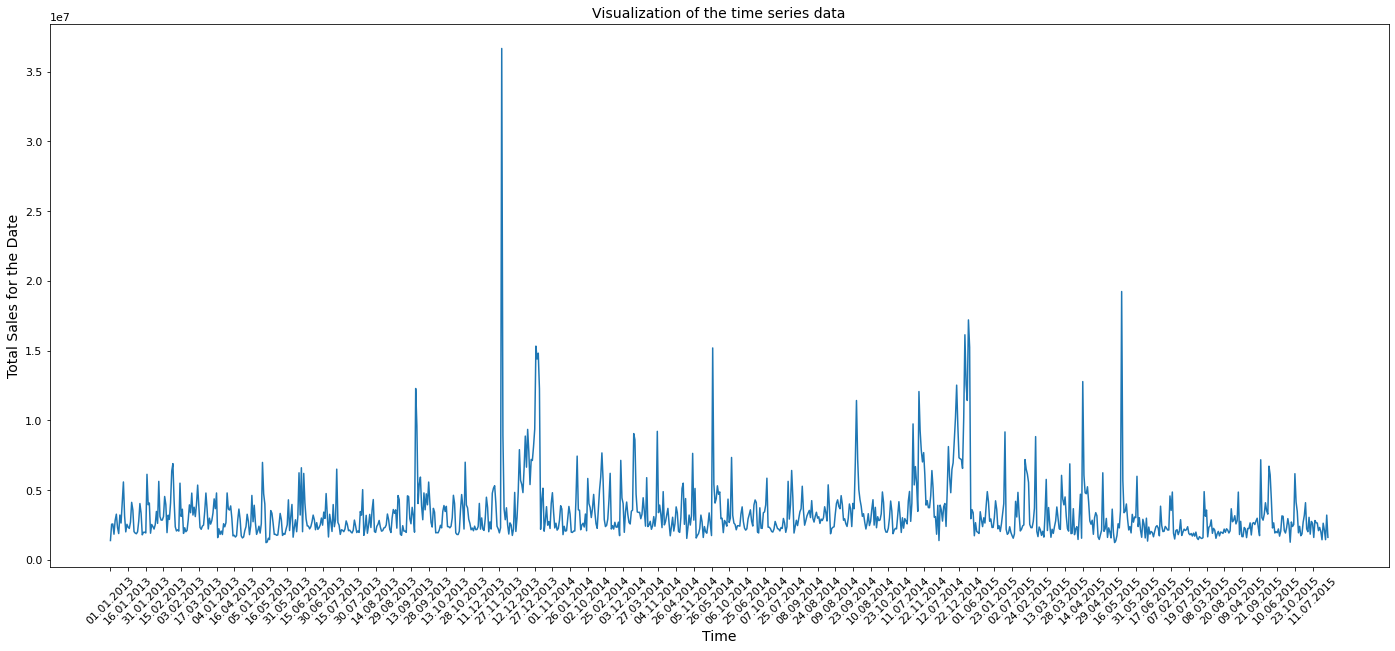

In [22]:
#Get all the values of the third field as a numpy array
tsdata = train_data.groupby(train_data.index).sum()['total_item_sales_day'].to_numpy()



#plot the data
fig = plt.figure(figsize = (24, 10))
plt.plot(train_data["date"].unique(), tsdata)
plt.xlabel("Time")
plt.ylabel("Total Sales for the Date")
# print(plt.xticks())
temp = [x for cnt, x in enumerate(plt.xticks()[0]) if cnt % 15 == 0]
plt.xticks(ticks= temp, rotation = 45)
plt.title("Visualization of the time series data")
plt.show()

In [23]:
# train_data.loc[train_data['item_cnt_day'] > 1]

In [24]:
total_sales_per_date_dict = {
    "Date": train_data["date"].unique(),
    "Total Sales": tsdata
}
total_sales_per_date = pd.DataFrame(total_sales_per_date_dict, columns=["Date", "Total Sales"])
total_sales_per_date['Date'] = pd.to_datetime(total_sales_per_date['Date'])
total_sales_per_date.index = total_sales_per_date.Date
total_sales_per_date

,Date,Total Sales
Date,,
2013-01-01,2013-01-01,1392063.00000
2013-01-02,2013-01-02,2560455.00000
2013-01-03,2013-01-03,2578443.00000
2013-01-04,2013-01-04,1845047.00000
2013-01-05,2013-01-05,2844712.98000
...,...,...
2015-12-06,2015-12-06,2632069.44000
2015-12-07,2015-12-07,2135140.98000
2015-12-08,2015-12-08,1453332.35000


In [25]:
train_data = train_data_copy

In [26]:
train_data.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00000,1.00000
1,03.01.2013,0,25,2552,899.00000,1.00000
2,05.01.2013,0,25,2552,899.00000,1.00000
3,06.01.2013,0,25,2554,1709.05000,1.00000
4,15.01.2013,0,25,2555,1099.00000,1.00000


In [27]:
negative_item_cnt_day_entries = train_data[train_data['item_cnt_day'] < 0]
negative_item_cnt_day_entries = negative_item_cnt_day_entries.reset_index()

negative_item_cnt_day_entries.count()

index             0
date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

In [28]:
negative_item_cnt_day_entries

,index,date,date_block_num,shop_id,item_id,item_price,item_cnt_day


In [29]:
train_data.iloc[2]

date              05.01.2013
date_block_num             0
shop_id                   25
item_id                 2552
item_price         899.00000
item_cnt_day         1.00000
Name: 2, dtype: object

In [30]:
mean = train_data[(train_data.shop_id==32) & (train_data.item_id==2973) & (train_data.date_block_num==4) & (train_data.item_price > 0)].item_price.mean()
train_data.loc[train_data.item_price < 0, 'item_price'] = mean

train_data.loc[(train_data.shop_id==32) & (train_data.item_id==2973) & (train_data.date_block_num==4) & (train_data.item_price > 0)]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484682,23.05.2013,4,32,2973,1249.00000,1.00000
484683,15.05.2013,4,32,2973,1874.00000,1.00000
484684,06.05.2013,4,32,2973,2499.00000,1.00000


In [31]:
#Merging datasets, can be used if required for visualization
train_merged = pd.merge(train_data, items_data, on='item_id', how='inner')
train_merged = pd.merge(train_merged, categories_data, on='item_category_id', how='inner')
train_merged = pd.merge(train_merged, shops_data, on='shop_id', how='inner')
# Inner join selects only those rows from both the tables which satisfy the join condition of ID

In [32]:
#Snippet of merged dataset
train_merged.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name
0,02.01.2013,0,59,22154,999.00000,1.00000,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир"""
1,26.04.2013,3,59,944,150.00000,1.00000,2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир"""
2,26.06.2013,5,59,944,199.50000,1.00000,2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир"""
3,20.07.2013,6,59,944,199.50000,1.00000,2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир"""
4,14.09.2013,8,59,944,299.00000,2.00000,2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир"""


In [33]:
#Extract and add some more features

train_merged['total_sales'] = train_merged.item_price * train_merged.item_cnt_day
train_merged['date'] = pd.to_datetime(train_merged.date)
train_merged['Month'] = train_merged['date'].dt.month
train_merged['Year'] = train_merged['date'].dt.year
train_merged['day_of_week'] = train_merged['date'].dt.day_name()

In [34]:
#snippet of train_merged
print(train_merged.head())

        date  date_block_num  shop_id  item_id  item_price  item_cnt_day  \
0 2013-02-01               0       59    22154   999.00000       1.00000   
1 2013-04-26               3       59      944   150.00000       1.00000   
2 2013-06-26               5       59      944   199.50000       1.00000   
3 2013-07-20               6       59      944   199.50000       1.00000   
4 2013-09-14               8       59      944   299.00000       2.00000   

           item_name  item_category_id item_category_name  \
0  ЯВЛЕНИЕ 2012 (BD)                37     Кино - Blu-Ray   
1          2012 (BD)                37     Кино - Blu-Ray   
2          2012 (BD)                37     Кино - Blu-Ray   
3          2012 (BD)                37     Кино - Blu-Ray   
4          2012 (BD)                37     Кино - Blu-Ray   

                shop_name  total_sales  Month  Year day_of_week  
0  Ярославль ТЦ "Альтаир"    999.00000      2  2013      Friday  
1  Ярославль ТЦ "Альтаир"    150.00000      

In [35]:
#drop entries with negative item count
train_merged=train_merged[train_merged.item_cnt_day>=0]

In [36]:
chosen_colors=cl.scales['5']['qual']['Paired']
ply.init_notebook_mode(connected=True)
temp_df = train_merged.groupby('date_block_num')[['total_sales']].sum().reset_index()
temp_df.astype('float')

fig = go.Figure()
fig.add_trace(go.Scatter(x=temp_df.date_block_num, y=temp_df.total_sales,
                    mode='lines',
                    line= dict(color='green', width=2)))

fig.update_layout(title='Monthly Revenue',
                   xaxis_title='Month',
                   yaxis_title='Total sales')

fig.show()

In [37]:
temp_df2 = train_merged.groupby('date_block_num')[['item_cnt_day']].sum().reset_index()
temp_df2.astype('float')

fig = go.Figure()
fig.add_trace(go.Scatter(x=temp_df2.date_block_num, y=temp_df2.item_cnt_day,
                    mode='lines',
                    line= dict(color='green', width=2)))

fig.update_layout(title='Monthly Item Count',
                   xaxis_title='Month',
                   yaxis_title='Item Count')

fig.show()

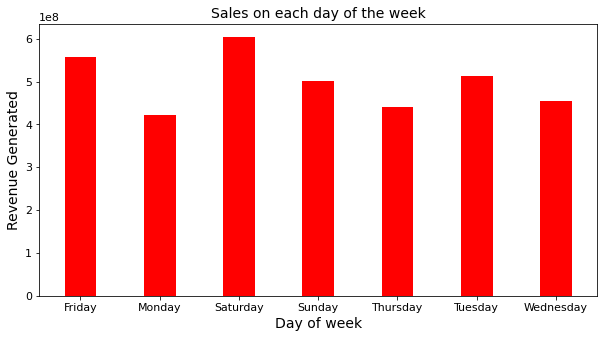

In [38]:
temp_df3 = train_merged.groupby('day_of_week')[['total_sales']].sum().reset_index()
fig = plt.figure(figsize = (10, 5))

# creating the bar plot 
plt.bar(temp_df3['day_of_week'], temp_df3['total_sales'], color ='red',  
        width = 0.4) 
  
plt.xlabel("Day of week") 
plt.ylabel("Revenue Generated") 
plt.title("Sales on each day of the week") 
plt.show()
#Friday, Saturday, Sunday highest in terms of sales

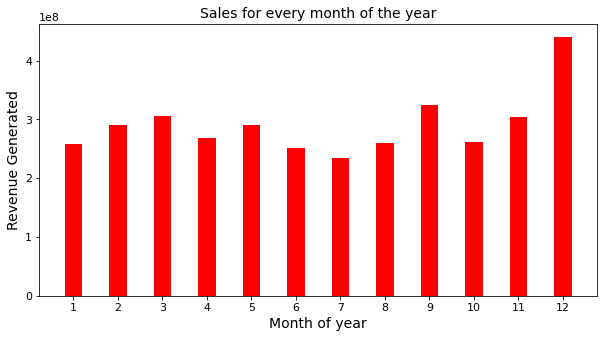

In [39]:
temp_df4 = train_merged.groupby('Month')[['total_sales']].sum().reset_index()
fig = plt.figure(figsize = (10, 5))

# creating the bar plot 
plt.bar(temp_df4['Month'], temp_df4['total_sales'], color ='red',  
        width = 0.4) 
  
plt.xlabel("Month of year") 
plt.ylabel("Revenue Generated") 
plt.title("Sales for every month of the year") 
plt.xticks([i for i in range(1, 13)])
plt.show()
#Most sales during december festive season

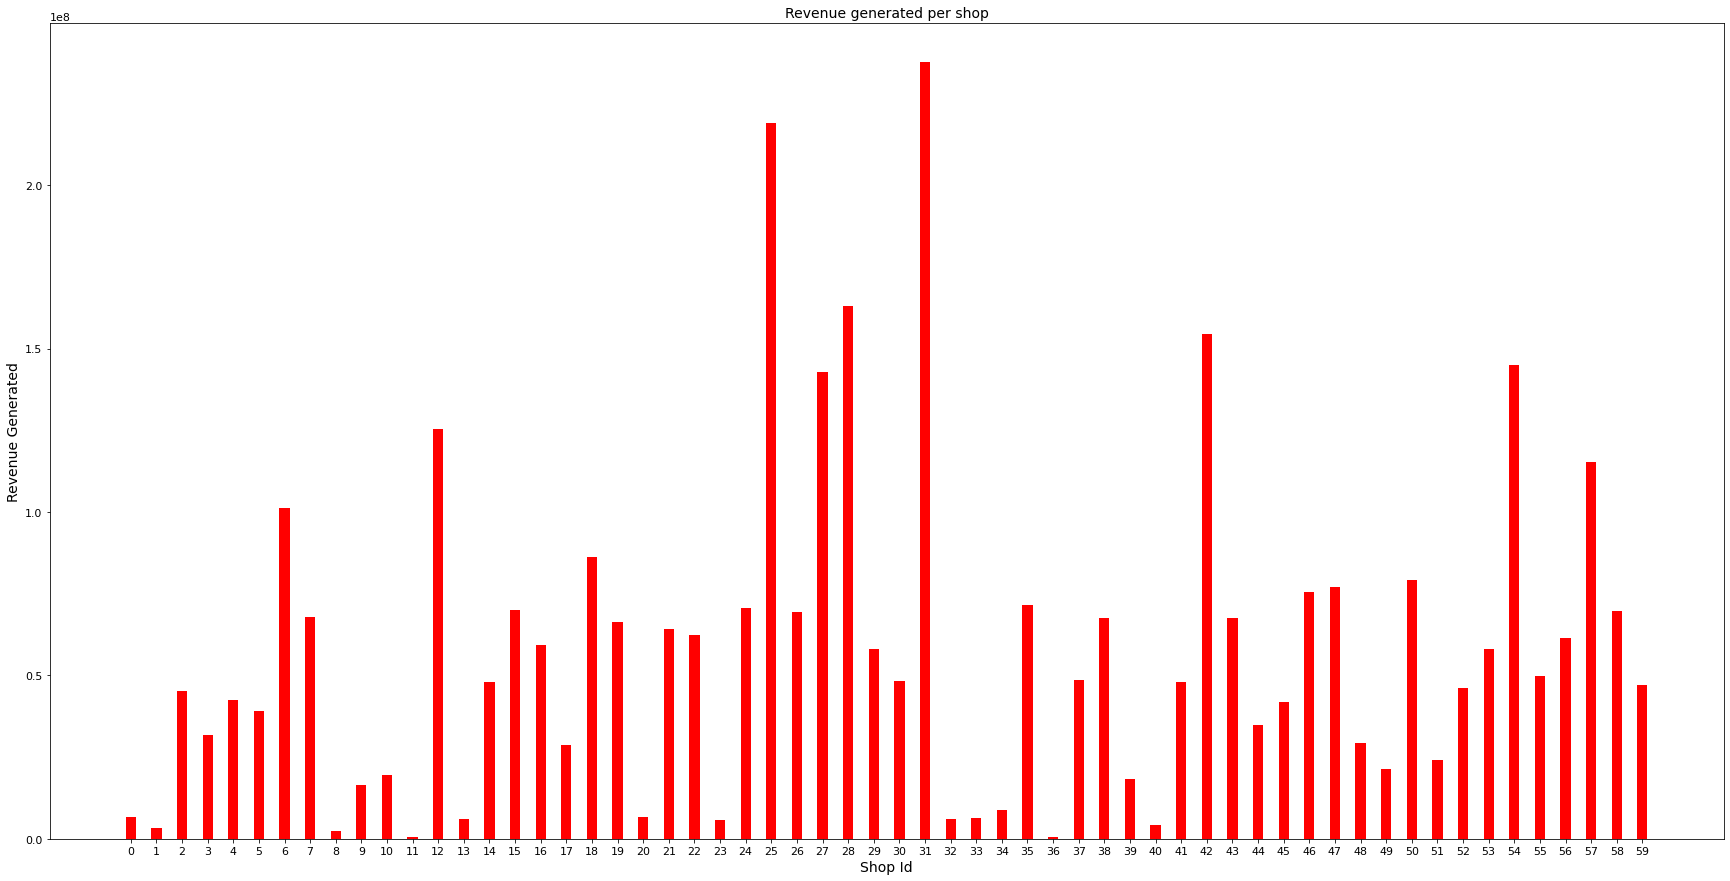

In [40]:
temp_df5 = train_merged.groupby('shop_id')[['total_sales']].sum().reset_index()
fig = plt.figure(figsize = (30, 15))

# creating the bar plot 
plt.bar(temp_df5['shop_id'], temp_df5['total_sales'], color ='red',  
        width = 0.4) 
  
plt.xlabel("Shop Id") 
plt.ylabel("Revenue Generated") 
plt.title("Revenue generated per shop") 
plt.xticks([i for i in range(60)])
plt.show()
#Most sales during december festive season

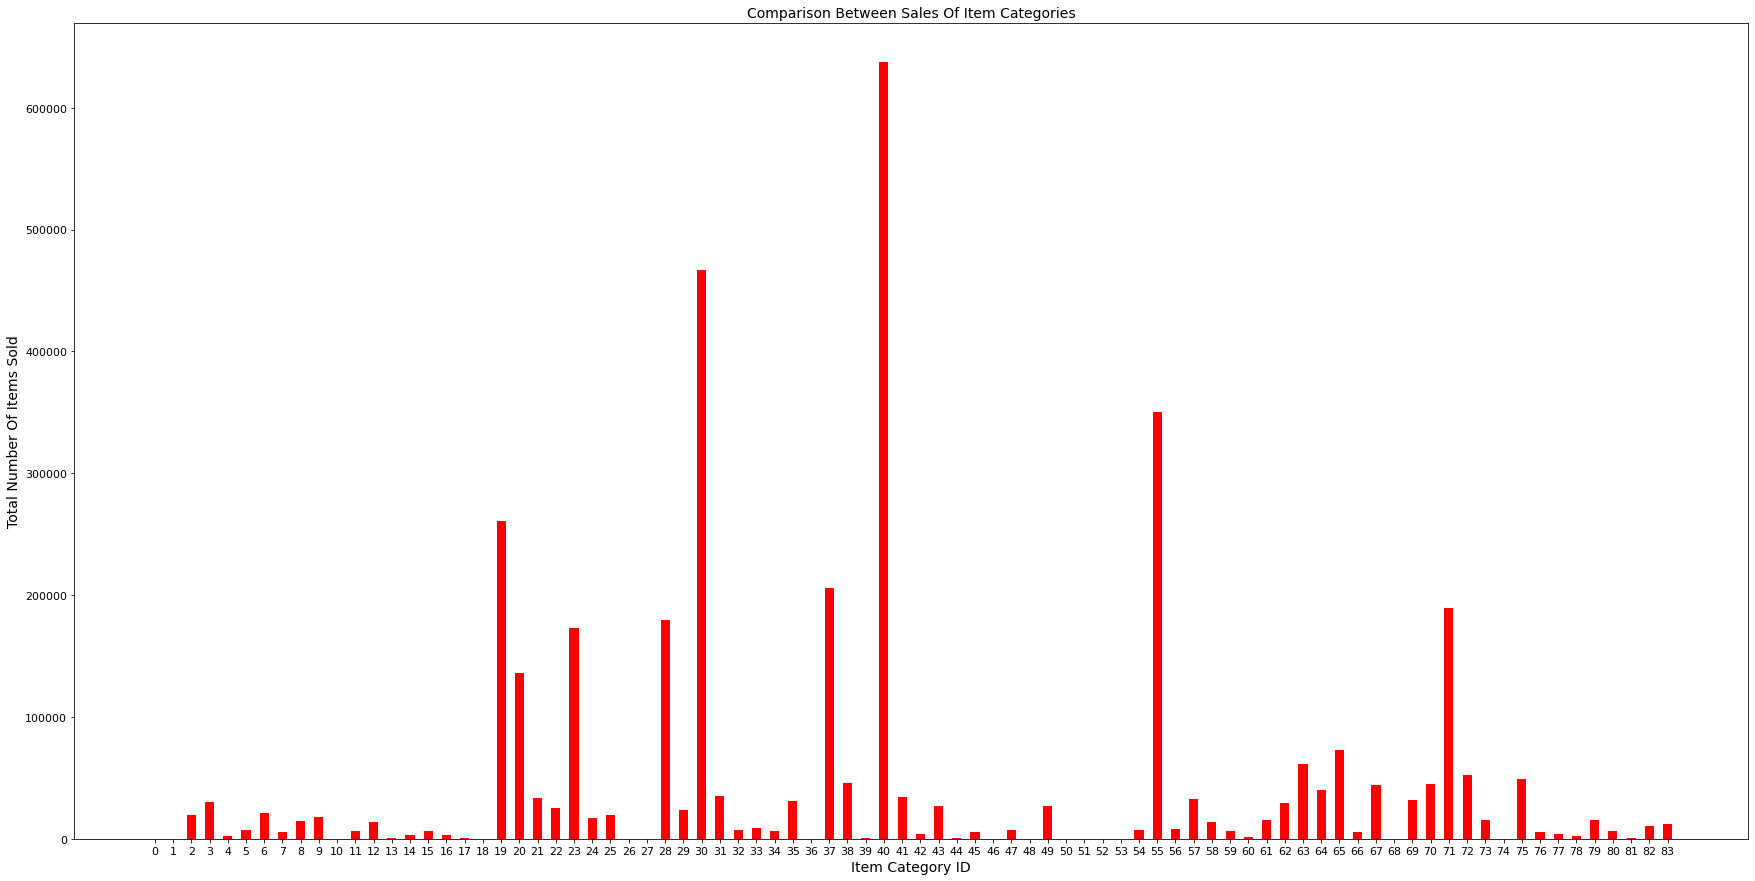

In [41]:
temp_df6 = train_merged.groupby('item_category_id')[['item_cnt_day']].sum().reset_index()
fig = plt.figure(figsize=(30,15))

plt.bar(temp_df6['item_category_id'],temp_df6['item_cnt_day'], color='red',width=0.5)

plt.xlabel("Item Category ID")
plt.ylabel("Total Number Of Items Sold")
plt.title("Comparison Between Sales Of Item Categories")
plt.xticks([i for i in range(84)])
plt.show()
# Maximum Sales in Item Category 40, followed by 30 and then 55

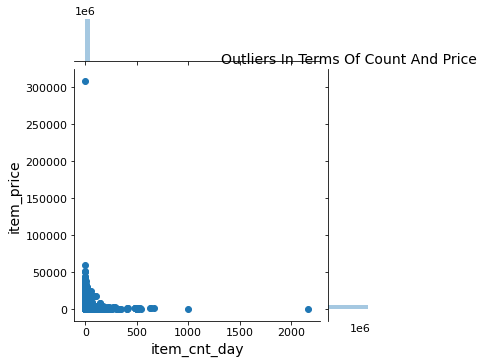

In [42]:
sns.jointplot(x="item_cnt_day", y="item_price", data=train_merged, height=5)
plt.title("Outliers In Terms Of Count And Price")
plt.show()
# Thus outliers are price greater than 50,000 and count greater than 500 and can cause significant
# amount of noise in the computation for prediction

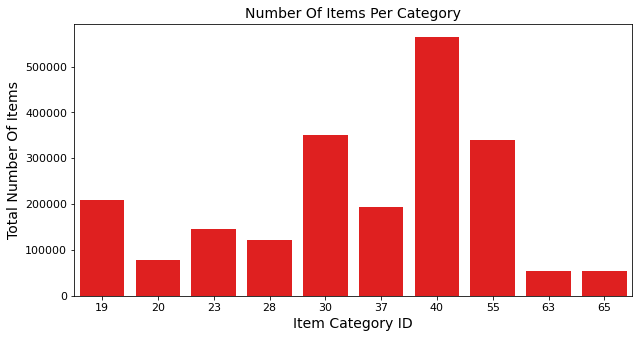

In [43]:
x=train_merged.groupby(['item_category_id']).count()
x=x.sort_values(by='item_id',ascending=False) # Sort In Descending Order Of The Number Of Items 
x=x.iloc[0:10].reset_index() # Select The Top 10 for the graph

plt.figure(figsize=(10,5))
y= sns.barplot(x.item_category_id, x.item_id, color='red')
plt.title("Number Of Items Per Category")
plt.ylabel('Total Number Of Items')
plt.xlabel('Item Category ID')
plt.show()
#Thus total number of sales that were high for item_categories 40,30 and 55 were due to proportionately
# high number of items in those categories

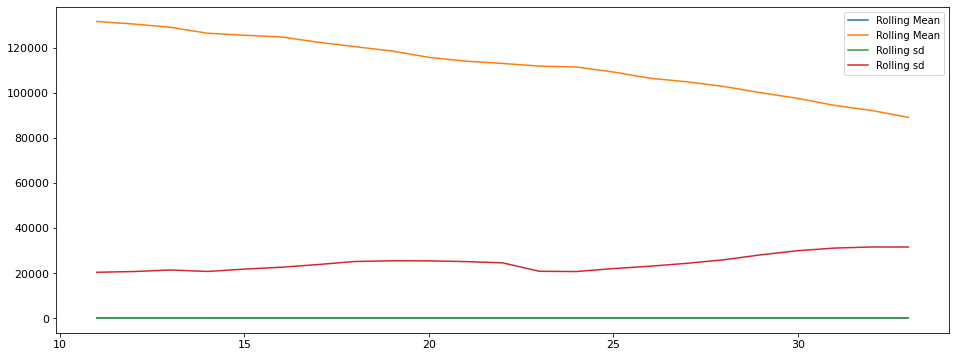

In [44]:
plt.figure(figsize=(16,6))
plt.plot(temp_df2.rolling(window=12,center=False).mean(),label='Rolling Mean');
plt.plot(temp_df2.rolling(window=12,center=False).std(),label='Rolling sd');
plt.legend();

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning:

the 'freq'' keyword is deprecated, use 'period' instead



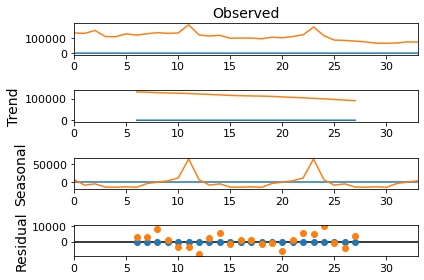

In [45]:
import statsmodels.api as sm
# multiplicative
res = sm.tsa.seasonal_decompose(temp_df2.values,freq=12,model="additive")
#plt.figure(figsize=(16,12))
fig = res.plot()
#fig.show()

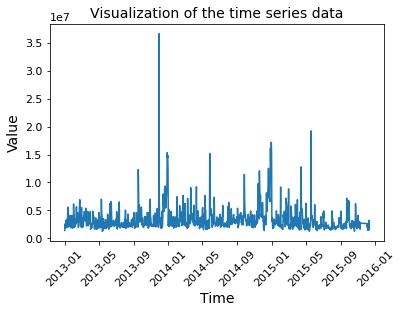

In [46]:
ts_col = "Total Sales"  #the name of the column with the TS data
#Get all the values of the third field as a numpy array
tsdata = total_sales_per_date[ts_col].to_numpy()


#plot the data
plt.plot(total_sales_per_date["Date"], tsdata)
plt.xlabel("Time")
plt.ylabel("Value")
plt.xticks(rotation = 45)
plt.title("Visualization of the time series data")
plt.show()

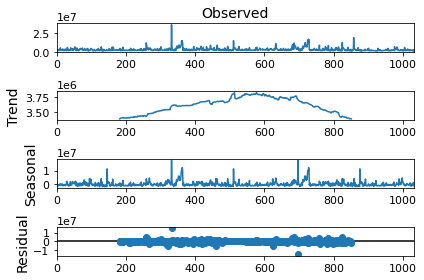

In [48]:
result = seasonal_decompose(total_sales_per_date['Total Sales'].to_numpy(), model='additive', period = 365)
result.plot()
plt.show()

In [52]:
total_sales_per_date

,Date,Total Sales
Date,,
2013-01-01,2013-01-01,1392063.00000
2013-01-02,2013-01-02,2560455.00000
2013-01-03,2013-01-03,2578443.00000
2013-01-04,2013-01-04,1845047.00000
2013-01-05,2013-01-05,2844712.98000
...,...,...
2015-12-06,2015-12-06,2632069.44000
2015-12-07,2015-12-07,2135140.98000
2015-12-08,2015-12-08,1453332.35000


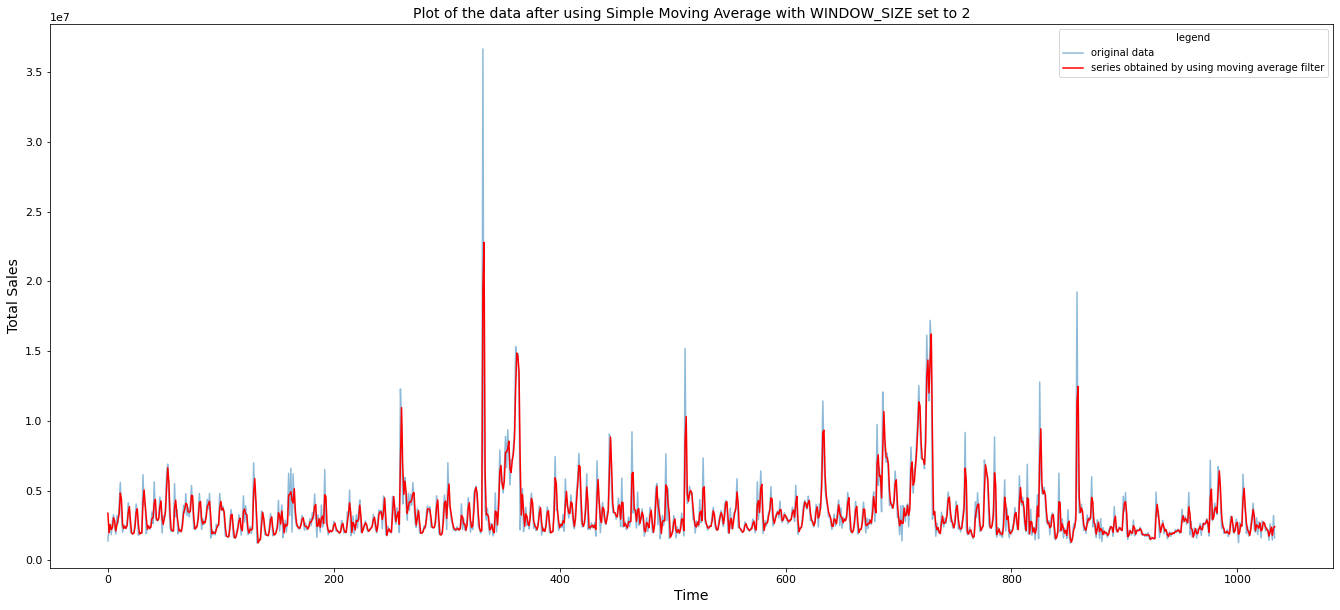

In [58]:
ts_col = 'Total Sales'

WINDOW_SIZE = 2 #this is the number of values that will be used to compute the SMA

# We create a vector of 1 row and WINDOW_SIZE number of columns each containing the value 1./WINDOW_SIZE
filter = np.ones((1,WINDOW_SIZE)) * 1./WINDOW_SIZE   #Try changing these weights

smoothed_series = []
for i in range(len(total_sales_per_date[ts_col])-WINDOW_SIZE+1):
    smoothed_series.append(np.sum(np.asarray(total_sales_per_date[ts_col][i:i+WINDOW_SIZE])*filter)) # numpy does element wise multiplication by default

# add dummy values in the beginning to align the smoothed series with the original data
smoothed_series = [total_sales_per_date[ts_col].mean() for i in range(WINDOW_SIZE-1)] + smoothed_series

assert len(smoothed_series) == len(total_sales_per_date[ts_col])

plt.figure(figsize = (23,10))
plt.plot(list(total_sales_per_date[ts_col]), alpha = 0.5)
plt.plot(smoothed_series, color = 'red')
plt.xlabel("Time")
plt.ylabel("Total Sales")
plt.title(f"Plot of the data after using Simple Moving Average with WINDOW_SIZE set to {WINDOW_SIZE}")
_=plt.legend(("original data",  "series obtained by using moving average filter"), title = "legend")
plt.show()

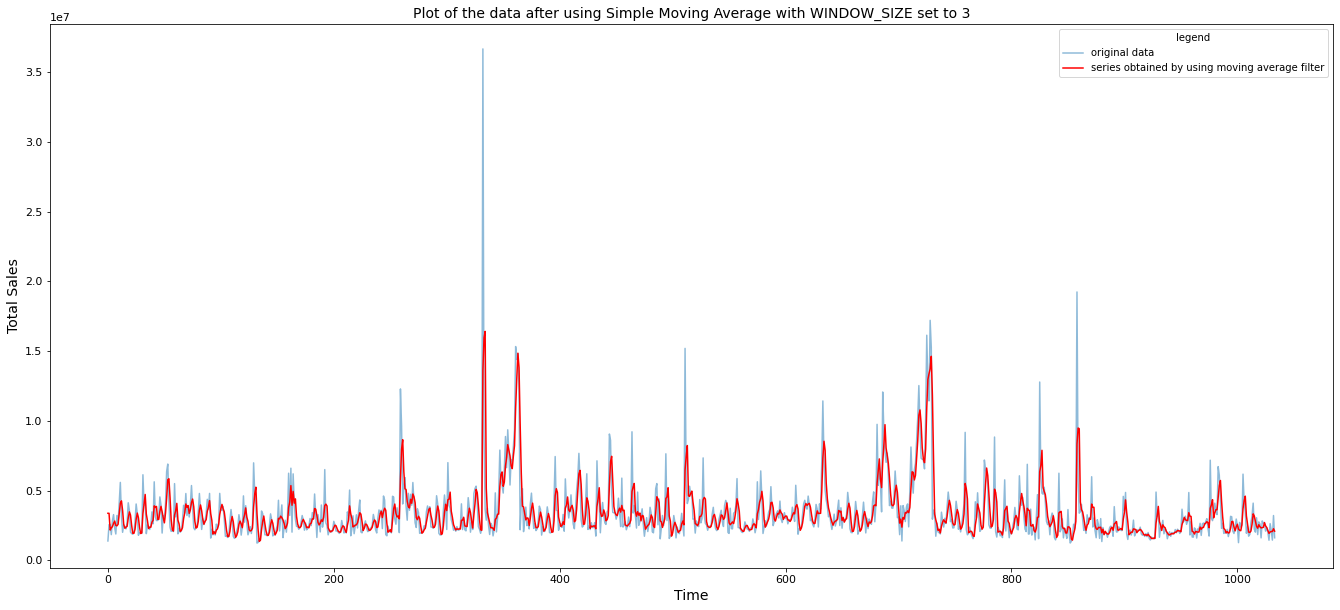

In [59]:
ts_col = 'Total Sales'

WINDOW_SIZE = 3 #this is the number of values that will be used to compute the SMA

# We create a vector of 1 row and WINDOW_SIZE number of columns each containing the value 1./WINDOW_SIZE
filter = np.ones((1,WINDOW_SIZE)) * 1./WINDOW_SIZE   #Try changing these weights

smoothed_series = []
for i in range(len(total_sales_per_date[ts_col])-WINDOW_SIZE+1):
    smoothed_series.append(np.sum(np.asarray(total_sales_per_date[ts_col][i:i+WINDOW_SIZE])*filter)) # numpy does element wise multiplication by default

# add dummy values in the beginning to align the smoothed series with the original data
smoothed_series = [total_sales_per_date[ts_col].mean() for i in range(WINDOW_SIZE-1)] + smoothed_series

assert len(smoothed_series) == len(total_sales_per_date[ts_col])

plt.figure(figsize = (23,10))
plt.plot(list(total_sales_per_date[ts_col]), alpha = 0.5)
plt.plot(smoothed_series, color = 'red')
plt.xlabel("Time")
plt.ylabel("Total Sales")
plt.title(f"Plot of the data after using Simple Moving Average with WINDOW_SIZE set to {WINDOW_SIZE}")
_=plt.legend(("original data",  "Series obtained by using a Simple moving average filter"), title = "legend")
plt.show()

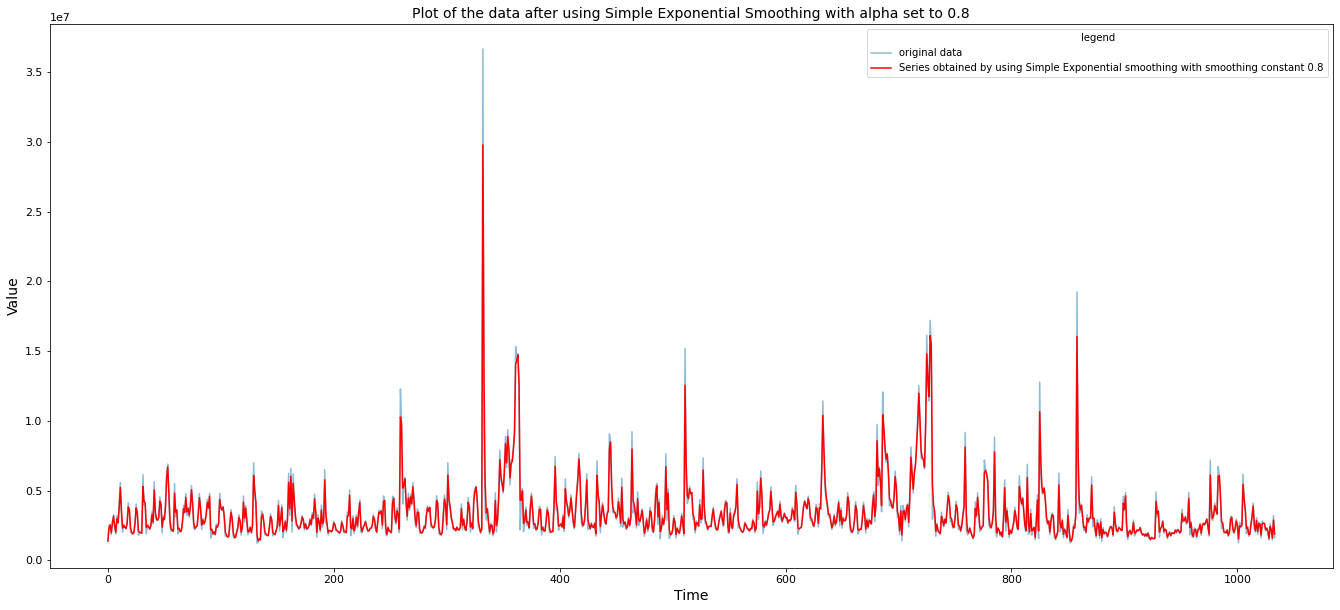

In [63]:
alpha = 0.8

# Function for Sigle exponential smoothing
def single_exp_smoothing(x, alpha):
    F = [x[0]] # first value is same as series
    for t in range(1, len(x)):
        F.append(alpha * x[t] + (1 - alpha) * F[t-1])
    return F

SES = single_exp_smoothing(total_sales_per_date[ts_col], alpha)

assert len(SES) == len(total_sales_per_date[ts_col])


plt.figure(figsize = (23,10))
plt.plot(list(total_sales_per_date[ts_col]), alpha = 0.5)  #this alpha is the opacity of the line plot
plt.plot(SES, color = 'red')

plt.xlabel("Time")
plt.ylabel("Value")
plt.title(f"Plot of the data after using Simple Exponential Smoothing with alpha set to {alpha}")
_=plt.legend(("original data",  f"Series obtained by using Simple Exponential smoothing with smoothing constant {alpha}"), title = "legend")

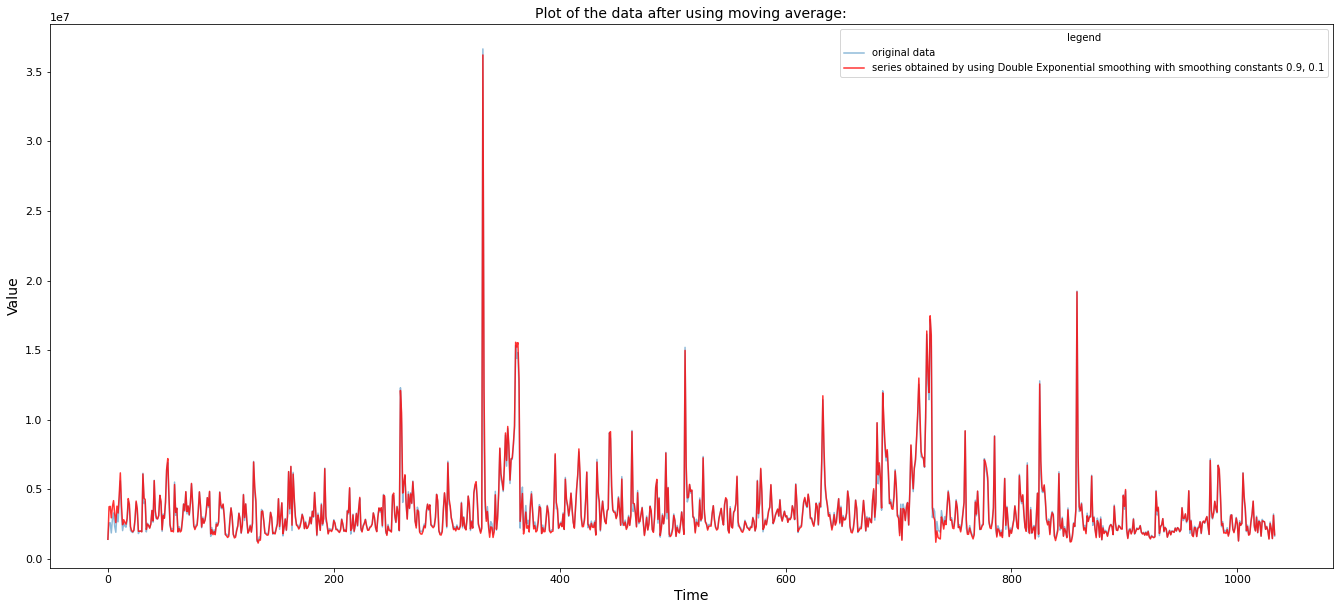

In [75]:
alpha_des, beta_des = 0.9, 0.1

def double_exp_smoothing(x, alpha, beta):
    yhat = [x[0]] # first value is same as series
    for t in range(1, len(x)):
        if t==1:
            F, T= x[0], x[1] - x[0]
        F_n_1, F = F, alpha*x[t] + (1-alpha)*(F+T)
        T=beta*(F-F_n_1)+(1-beta)*T
        yhat.append(F+T)
    return yhat

    
DES = double_exp_smoothing(total_sales_per_date[ts_col], alpha_des, beta_des)

assert len(DES) == len(total_sales_per_date[ts_col])

plt.figure(figsize = (23,10))
plt.plot(list(total_sales_per_date[ts_col]), alpha = 0.5)  #this alpha is the opacity of the line plot
plt.plot(DES, color = 'red', alpha = 0.8)

plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Plot of the data after using moving average:")
_=plt.legend(("original data",  f"series obtained by using Double Exponential smoothing with smoothing constants {alpha_des}, {beta_des}"), title = "legend")

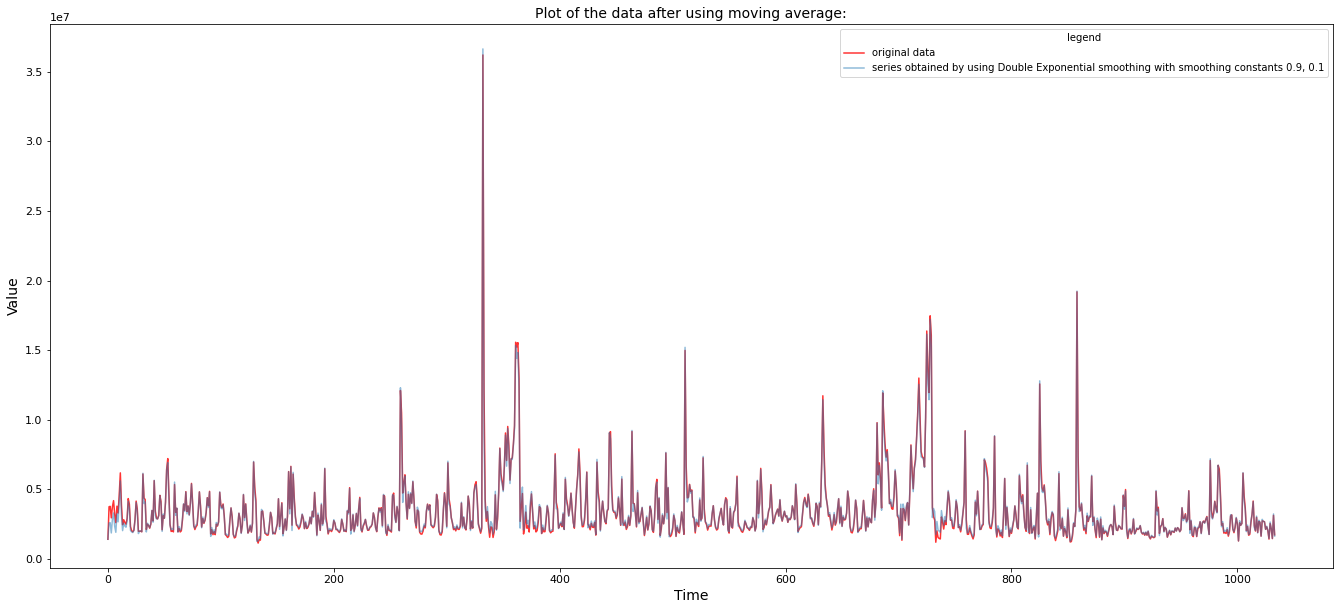

In [76]:
alpha_des, beta_des = 0.9, 0.1

def double_exp_smoothing(x, alpha, beta):
    yhat = [x[0]] # first value is same as series
    for t in range(1, len(x)):
        if t==1:
            F, T= x[0], x[1] - x[0]
        F_n_1, F = F, alpha*x[t] + (1-alpha)*(F+T)
        T=beta*(F-F_n_1)+(1-beta)*T
        yhat.append(F+T)
    return yhat

    
DES = double_exp_smoothing(total_sales_per_date[ts_col], alpha_des, beta_des)

assert len(DES) == len(total_sales_per_date[ts_col])

plt.figure(figsize = (23,10))
plt.plot(DES, color = 'red', alpha = 0.8)
plt.plot(list(total_sales_per_date[ts_col]), alpha = 0.5)  #this alpha is the opacity of the line plot


plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Plot of the data after using moving average:")
_=plt.legend(("original data",  f"series obtained by using Double Exponential smoothing with smoothing constants {alpha_des}, {beta_des}"), title = "legend")

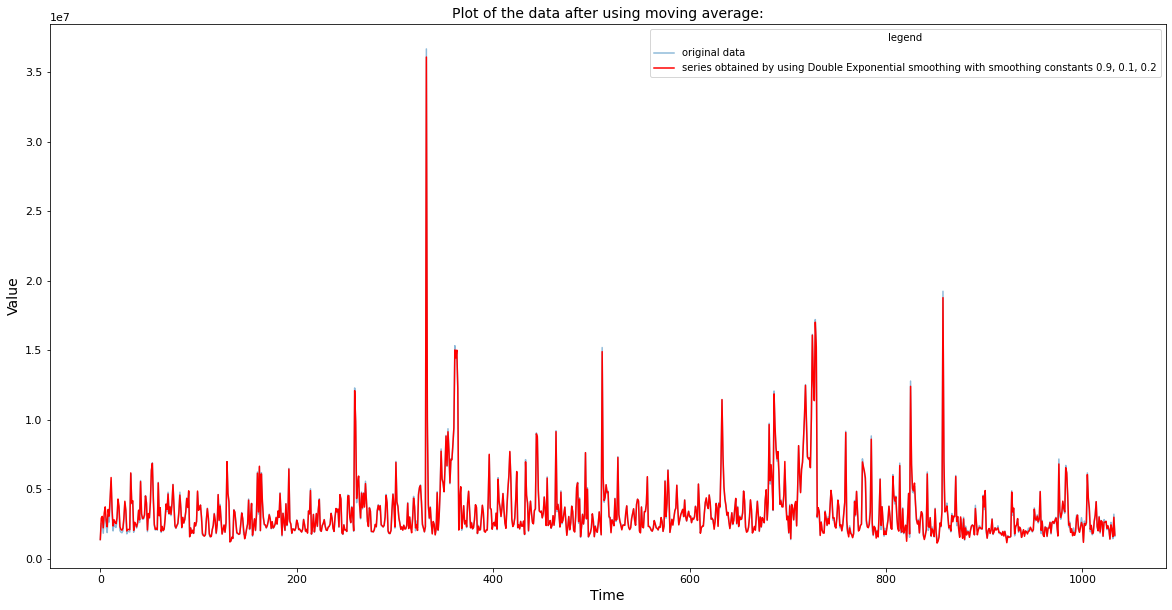

In [85]:
alpha_tes, beta_tes, gamma_tes = 0.9, 0.05, 0.2
# Capture seasonality component
def initialize_T(x, seasonLength):
    total=0.0
    for i in range(seasonLength):
        total+=float(x[i+seasonLength]-x[i])/seasonLength
    return total

initialize_T(total_sales_per_date[ts_col], 365)

# Initialize seasonal trend
def initialize_seasonalilty(x, seasonLength):
    seasons={}
    seasonsMean=[]
    num_season=int(len(x)/seasonLength)
    # Compute season average
    for i in range(num_season):
        seasonsMean.append(sum(x[seasonLength*i:seasonLength*i+seasonLength])/float(seasonLength))
    
    # compute season intial values
    for i in range(seasonLength):
        tot=0.0
        for j in range(num_season):
            tot+=x[seasonLength*j+i]-seasonsMean[j]
        seasons[i]=tot/num_season
    return seasons
            
initialize_seasonalilty(total_sales_per_date[ts_col], 365)   
        

# Triple Exponential Smoothing Forecast
def triple_exp_smoothing(x, seasonLength, alpha, beta, gamma):
    yhat=[]
    S = initialize_seasonalilty(x, seasonLength)
    for i in range(len(x)):
        if i == 0:
            F = x[0]
            T = initialize_T(x, seasonLength)
            yhat.append(x[0])
            continue
        if i >= len(x):
            m = i - len(x) + 1
            yhat.append((F + m*T) + S[i%seasonLength])
        else:
            obsval = x[i]
            F_last, F= F, alpha*(obsval-S[i%seasonLength]) + (1-alpha)*(F+T)
            T = beta * (F-F_last) + (1-beta)*T
            S[i%seasonLength] = gamma*(obsval-F) + (1-gamma)*S[i%seasonLength]
            yhat.append(F+T+S[i%seasonLength])
    return yhat


TES =  triple_exp_smoothing(total_sales_per_date[ts_col], 365, alpha_tes, beta_tes, gamma_tes)

assert len(TES) == len(total_sales_per_date[ts_col])

plt.figure(figsize = (20,10))
plt.plot(list(total_sales_per_date[ts_col]), alpha = 0.5)  #this alpha is the opacity of the line plot
plt.plot(TES, color = 'red')

plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Plot of the data after using moving average:")
_=plt.legend(("original data",  "series obtained by using Double Exponential smoothing with smoothing constants %.1f, %.1f, %.1f"%(alpha_tes, beta_tes, gamma_tes)), title = "legend")

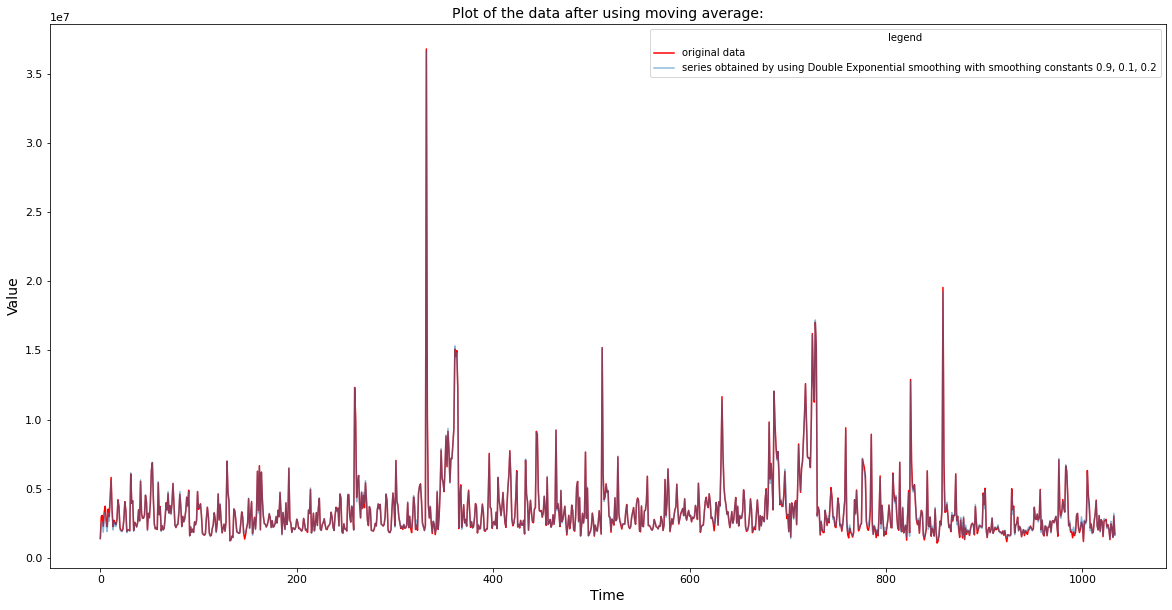

In [79]:
alpha_tes, beta_tes, gamma_tes = 0.9, 0.1, 0.2
# Capture seasonality component
def initialize_T(x, seasonLength):
    total=0.0
    for i in range(seasonLength):
        total+=float(x[i+seasonLength]-x[i])/seasonLength
    return total

initialize_T(total_sales_per_date[ts_col], 365)

# Initialize seasonal trend
def initialize_seasonalilty(x, seasonLength):
    seasons={}
    seasonsMean=[]
    num_season=int(len(x)/seasonLength)
    # Compute season average
    for i in range(num_season):
        seasonsMean.append(sum(x[seasonLength*i:seasonLength*i+seasonLength])/float(seasonLength))
    
    # compute season intial values
    for i in range(seasonLength):
        tot=0.0
        for j in range(num_season):
            tot+=x[seasonLength*j+i]-seasonsMean[j]
        seasons[i]=tot/num_season
    return seasons
            
initialize_seasonalilty(total_sales_per_date[ts_col], 365)   
        

# Triple Exponential Smoothing Forecast
def triple_exp_smoothing(x, seasonLength, alpha, beta, gamma):
    yhat=[]
    S = initialize_seasonalilty(x, seasonLength)
    for i in range(len(x)):
        if i == 0:
            F = x[0]
            T = initialize_T(x, seasonLength)
            yhat.append(x[0])
            continue
        if i >= len(x):
            m = i - len(x) + 1
            yhat.append((F + m*T) + S[i%seasonLength])
        else:
            obsval = x[i]
            F_last, F= F, alpha*(obsval-S[i%seasonLength]) + (1-alpha)*(F+T)
            T = beta * (F-F_last) + (1-beta)*T
            S[i%seasonLength] = gamma*(obsval-F) + (1-gamma)*S[i%seasonLength]
            yhat.append(F+T+S[i%seasonLength])
    return yhat


TES =  triple_exp_smoothing(total_sales_per_date[ts_col], 365, alpha_tes, beta_tes, gamma_tes)

assert len(DES) == len(total_sales_per_date[ts_col])

plt.figure(figsize = (20,10))
plt.plot(TES, color = 'red')
plt.plot(list(total_sales_per_date[ts_col]), alpha = 0.5)  #this alpha is the opacity of the line plot


plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Plot of the data after using moving average:")
_=plt.legend(("original data",  "series obtained by using Double Exponential smoothing with smoothing constants %.1f, %.1f, %.1f"%(alpha_tes, beta_tes, gamma_tes)), title = "legend")

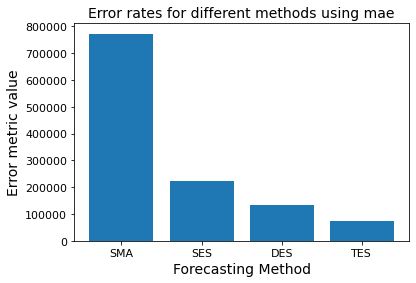

In [86]:
def mae(y, yhat):
  y = np.asarray(y)
  yhat = np.asarray(yhat)
  return np.mean(np.abs(y-yhat))

def mape(y, yhat):
  y = np.asarray(y)
  yhat = np.asarray(yhat)
  return np.mean(np.abs(y-yhat)/y) * 100

def mse(y, yhat):
  y = np.asarray(y)
  yhat = np.asarray(yhat)
  return np.mean((y-yhat)**2)

def rmse(y, yhat):
  y = np.asarray(y)
  yhat = np.asarray(yhat)
  return np.sqrt(np.mean((y-yhat)**2))

preds = [smoothed_series, SES, DES, TES]
labels = ["SMA", "SES", "DES", "TES"]
metric = mae

y = [metric(i, total_sales_per_date[ts_col]) for i in preds]
plt.bar(labels, y)
plt.xlabel("Forecasting Method")
plt.ylabel("Error metric value")
plt.title("Error rates for different methods using %s"%metric.__name__)
plt.show()